In [5]:
%config IPCompleter.greedy=True
from IPython.display import IFrame

import pandas as pd
import numpy as np
import string
import math

import scipy.stats as sts

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn import preprocessing as prep
import sklearn.metrics as metrics
import sklearn.model_selection as model_selection
from sklearn import discriminant_analysis as disan
from sklearn import calibration as calib
from sklearn import linear_model as lm
from sklearn import svm
from sklearn import gaussian_process as gaup
from sklearn import mixture as mix
from sklearn import tree
from sklearn import ensemble as ens

import tensorflow as tf
from tensorflow import keras

# from keras import models as kermdls
# from keras import layers as kerlrs
# from keras import metrics as kmetrics

from hyperas import optim
from hyperas.distributions import choice, uniform
from hyperopt import Trials, STATUS_OK, tpe

import pickle

import nilearn as nl
from nilearn import plotting, image
from nilearn import datasets
import nibabel as nb
import h5py

import os

import time

import datetime

Using TensorFlow backend.


In [2]:
tf.test.is_built_with_cuda()

True

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [4]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12196378803354003348
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 5307412190231196797
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6589725830
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4391274944931601969
physical_device_desc: "device: 0, name: GeForce GTX 1070 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3003830579972060277
physical_device_desc: "device: XLA_GPU device"
]


In [5]:
data = pd.read_csv('00_Data/train_scores.csv')
data

,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
0,10001,57.436077,30.571975,62.553736,53.325130,51.427998
1,10002,59.580851,50.969456,67.470628,60.651856,58.311361
2,10004,71.413018,53.152498,58.012103,52.418389,62.536641
3,10005,66.532630,NaN,NaN,52.108977,69.993075
4,10007,38.617381,49.197021,65.674285,40.151376,34.096421
...,...,...,...,...,...,...
5872,21746,14.257265,21.358872,61.165998,51.778483,54.640179
5873,21747,55.456978,68.169675,29.907995,55.349257,54.019517
5874,21750,48.948756,55.114811,60.878271,38.617246,50.679885
5875,21752,66.532630,59.844808,72.303110,55.458281,46.870235


In [6]:
data.isnull().sum()

Id                0
age               0
domain1_var1    438
domain1_var2    438
domain2_var1     39
domain2_var2     39
dtype: int64

In [ ]:
data = data.dropna()

In [7]:
def get_inputs(idx, y):
#     print(idx, y)
#     idx, y = idx_label_pair
    patient_SM = h5py.File('00_Data/fMRI_train/{0}.mat'.format(idx), mode='r')
    patient_SM = np.array(patient_SM.get('SM_feature'))
    
    k = 2
    ki_padding = 3
    
    arr_regions = []
    for i in range(patient_SM.shape[0]):
        sample_map = patient_SM[i,:,:,:]
        # padding MRI map
        map_shape = sample_map.shape
        shape_pad = ((map_shape[0]//k + 1)*k - map_shape[0],
                     (map_shape[1]//k + 1)*k - map_shape[1],
                     (map_shape[2]//k + 1)*k - map_shape[2])

        npad = ((shape_pad[0]//2, (shape_pad[0]//2 if shape_pad[0]%2==0 else shape_pad[0]//2+1)),    
                (shape_pad[1]//2, (shape_pad[1]//2 if shape_pad[1]%2==0 else shape_pad[1]//2+1)),    
                (shape_pad[2]//2, (shape_pad[2]//2 if shape_pad[2]%2==0 else shape_pad[2]//2+1)))

        sample_map_padded = np.pad(sample_map, pad_width=npad, mode='constant', constant_values=0)

        sx = sample_map_padded.shape[0] / k
        sy = sample_map_padded.shape[1] / k
        sz = sample_map_padded.shape[2] / k
        for kz in range(k):
            for ky in range(k):
                for kx in range(k):
                    ki_region = sample_map_padded[int(kx*sx): int(kx*sx + sx - 1), 
                                                 int(ky*sy): int(ky*sy + sy - 1), 
                                                 int(kz*sz): int(kz*sz + sz - 1)]
                    # padding i-th region by 3 pixels
                    ki_region_padded = np.pad(ki_region, pad_width=ki_padding, mode='constant', constant_values=0)
                    arr_regions.append(ki_region_padded)
    X = np.stack(arr_regions, axis=3)
#     print(X.shape, y)
    return X, y

In [8]:
def map_decorator(func):
    def wrapper(idx, label):
        # Use a tf.py_function to prevent auto-graph from compiling the method
        return tf.py_function(
            func,
            inp=(idx, label),
            Tout=(tf.float64, tf.float64))
    return wrapper

In [9]:
def get_dataset(data, idx, label, batch_size):
    data = tf.data.Dataset.from_tensor_slices((data['Id'].values, data['age'].values))
    data = data.map(map_decorator(get_inputs), 
                     num_parallel_calls=tf.data.experimental.AUTOTUNE, 
                     deterministic=True)
    data = data.cache(filename='99_Cache/cache.dat')
    data = data.batch(batch_size, drop_remainder=True)
    data = data.prefetch(tf.data.experimental.AUTOTUNE)
    return data

In [11]:
train, test = model_selection.train_test_split(data, train_size=0.2, test_size=0.1, shuffle=True, random_state=30)
train, val = model_selection.train_test_split(train, test_size=0.2, shuffle=True, random_state=30)

In [12]:
idx = 'Id'
label = 'age'
batch_size = 16

ds_train = get_dataset(train, idx, label, batch_size)
ds_val = get_dataset(val, idx, label, batch_size)
ds_test = get_dataset(test, idx, label, batch_size)

In [13]:
# start_time = time.perf_counter()
# for f in ds_train.take(1):
#     pass
# tf.print("Execution time:", time.perf_counter() - start_time)

In [13]:
INPUT_SHAPE = (32,37,32,424)

In [15]:
# INPUT_SHAPE = (58, 69, 59, 53)

In [14]:
inputs = keras.layers.Input(shape=INPUT_SHAPE)
print(inputs)

# convolution block #1
block_1 = keras.layers.Conv3D(64, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                              kernel_initializer=keras.initializers.he_normal(seed=30),
                              bias_initializer=keras.initializers.Constant(0.01))(inputs)
print(block_1)
block_1 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(block_1)
print(block_1)
block_1 = keras.layers.Conv3D(64, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                              kernel_initializer=keras.initializers.he_normal(seed=30),
                              bias_initializer=keras.initializers.Constant(0.01))(block_1)
print(block_1)
block_1 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(block_1)
print(block_1)
block_1 = keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2,2,2))(block_1)
print(block_1)
block_1 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                          beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                          moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                          beta_constraint=None, gamma_constraint=None)(block_1)
print(block_1, '\n')


# convolution block #2
block_2 = keras.layers.Conv3D(32, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                              kernel_initializer=keras.initializers.he_normal(seed=30),
                              bias_initializer=keras.initializers.Constant(0.01))(block_1)
print(block_2)
block_2 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(block_2)
print(block_2)
block_2 = keras.layers.Conv3D(32, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                              kernel_initializer=keras.initializers.he_normal(seed=30),
                              bias_initializer=keras.initializers.Constant(0.01))(block_2)
print(block_2)
block_2 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(block_2)
print(block_2)
block_2 = keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2,2,2))(block_2)
print(block_2)
block_2 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                          beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                          moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                          beta_constraint=None, gamma_constraint=None)(block_2)
print(block_2, '\n')

# convolution block #3
block_3 = keras.layers.Conv3D(16, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                              kernel_initializer=keras.initializers.he_normal(seed=30),
                              bias_initializer=keras.initializers.Constant(0.01))(block_2)
print(block_3)
block_3 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(block_3)
print(block_3)
block_3 = keras.layers.Conv3D(16, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                              kernel_initializer=keras.initializers.he_normal(seed=30),
                              bias_initializer=keras.initializers.Constant(0.01))(block_3)
print(block_3)
block_3 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(block_3)
print(block_3)
block_3 = keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2,2,2))(block_3)
print(block_3)
block_3 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                          beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                          moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                          beta_constraint=None, gamma_constraint=None)(block_3)
print(block_3, '\n')

# convolution block #4
block_4 = keras.layers.Conv3D(8, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                              kernel_initializer=keras.initializers.he_normal(seed=30),
                              bias_initializer=keras.initializers.Constant(0.01))(block_3)
print(block_4)
block_4 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(block_4)
print(block_4)
block_4 = keras.layers.Conv3D(8, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                              kernel_initializer=keras.initializers.he_normal(seed=30),
                              bias_initializer=keras.initializers.Constant(0.01))(block_4)
print(block_4)
block_4 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(block_4)
print(block_4)
block_4 = keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2,2,2))(block_4)
print(block_4)
block_4 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                          beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                          moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                          beta_constraint=None, gamma_constraint=None)(block_4)
print(block_4, '\n')

flatten = keras.layers.Flatten(data_format='channels_last')(block_4)

# hidden layer
dense = keras.layers.Dense(256, activation='elu')(flatten)
print(dense, '\n')

# output
outputs = keras.layers.Dense(1, activation='linear')(dense)
print(outputs)

Tensor("input_1:0", shape=(None, 32, 37, 32, 424), dtype=float32)
Tensor("conv3d/Identity:0", shape=(None, 32, 37, 32, 64), dtype=float32)
Tensor("p_re_lu/Identity:0", shape=(None, 32, 37, 32, 64), dtype=float32)
Tensor("conv3d_1/Identity:0", shape=(None, 32, 37, 32, 64), dtype=float32)
Tensor("p_re_lu_1/Identity:0", shape=(None, 32, 37, 32, 64), dtype=float32)
Tensor("max_pooling3d/Identity:0", shape=(None, 16, 18, 16, 64), dtype=float32)
Tensor("batch_normalization/Identity:0", shape=(None, 16, 18, 16, 64), dtype=float32) 

Tensor("conv3d_2/Identity:0", shape=(None, 16, 18, 16, 32), dtype=float32)
Tensor("p_re_lu_2/Identity:0", shape=(None, 16, 18, 16, 32), dtype=float32)
Tensor("conv3d_3/Identity:0", shape=(None, 16, 18, 16, 32), dtype=float32)
Tensor("p_re_lu_3/Identity:0", shape=(None, 16, 18, 16, 32), dtype=float32)
Tensor("max_pooling3d_1/Identity:0", shape=(None, 8, 9, 8, 32), dtype=float32)
Tensor("batch_normalization_1/Identity:0", shape=(None, 8, 9, 8, 32), dtype=float32) 



In [15]:
model = keras.Model(inputs=inputs, outputs=outputs, name='test_model')

In [16]:
optim = keras.optimizers.Adam(lr=0.00001,
                                 beta_1=0.99,
                                 beta_2=0.999,
                                 amsgrad=False)
        
METRICS = [keras.metrics.RootMeanSquaredError(name='rmse'),
           keras.metrics.MeanSquaredError(name='mse'),
           keras.metrics.MeanAbsoluteError(name='mae')]

In [17]:
model.compile(loss='mean_squared_error', metrics=METRICS, optimizer=optim)

In [18]:
# Define the checkpoint directory to store the checkpoints
checkpoint_dir = './99_Training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

In [19]:
log_dir = './99_Logs/mri/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks = [tf.keras.callbacks.TensorBoard(log_dir=log_dir),
             tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                                save_weights_only=False)]

In [20]:
with tf.device('/GPU:0'):
    hist = model.fit(ds_train,
                     validation_data=ds_val,
                     callbacks=callbacks,
                     epochs=100,
                     verbose=1)

Epoch 1/100
58/58 [==============================] - ETA: 0s - loss: 2559.5330 - rmse: 50.5918 - mse: 2559.5330 - mae: 48.5955   ETA: 4:04 - loss: 2681.1365 - rmse: 51.7797 - mse - ETA: 2:37 - loss: 2671.8655 - rmse: 51.6901 - mse: 2671.8655 - mae: 49. - ETA: 2:22 - loss: 2657.2891 - rmse: 51.5489WARNING:tensorflow:From c:\00_data\python38\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py:1813: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./99_Training_checkpoints\ckpt_1\assets
58/58 [==============================] - 576s 10s/step - loss: 2559.5330 - rmse: 50.5918 - mse: 2559.5330 - mae: 48.5955 - val_loss: 2476.1733 - val_rmse: 49.7612 - val_mse: 2476.1733 - val_mae: 47.7214
Epoch 2/100
58/58 [==============================] - 609s 11s/step -

In [21]:
with tf.device('/GPU:0'):
    results = model.evaluate(ds_test, verbose=1)

36/36 [==============================] - 359s 10s/step - loss: 169.1684 - rmse: 13.0065 - mse: 169.1684 - mae: 10.3892


Text(0.5, 1.0, 'Metric')

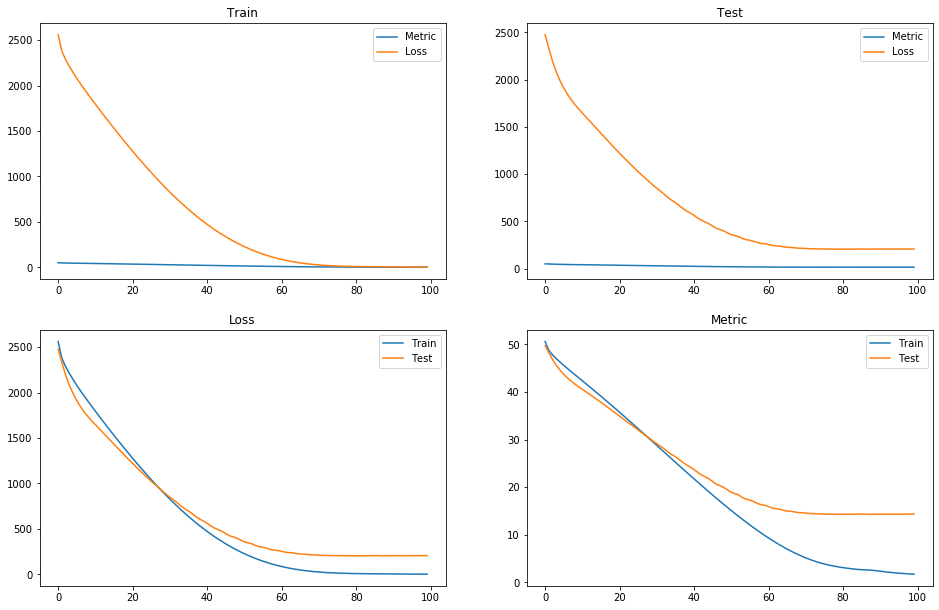

In [22]:
    fig = plt.figure()
    fig.set_size_inches(16,16)

    ax=fig.add_subplot(3,2,1)
    ax.plot(hist.history['rmse'])
    ax.plot(hist.history['mse'])
    ax.legend(['Metric', 'Loss'])
    ax.set_title('Train')

    ax=fig.add_subplot(3,2,2)
    ax.plot(hist.history['val_rmse'])
    ax.plot(hist.history['val_mse'])
    ax.legend(['Metric', 'Loss'])
    ax.set_title('Test')

    ax=fig.add_subplot(3,2,3)
    ax.plot(hist.history['mse'])
    ax.plot(hist.history['val_mse'])
    ax.legend(['Train', 'Test'])
    ax.set_title('Loss')

    ax=fig.add_subplot(3,2,4)
    ax.plot(hist.history['rmse'])
    ax.plot(hist.history['val_rmse'])
    ax.legend(['Train', 'Test'])
    ax.set_title('Metric')

In [6]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [33]:
# logdir = './99_Logs/train'

In [7]:
%tensorboard --logdir ./99_Logs

Reusing TensorBoard on port 6006 (pid 4836), started 0:03:04 ago. (Use '!kill 4836' to kill it.)

In [3]:
!kill 4836

'kill' is not recognized as an internal or external command,
operable program or batch file.
